In [115]:
# let's import all the relevant python libraries for this project 
import pandas as pd
import folium
from folium import plugins
import ipywidgets
import geocoder
import geopy
import numpy as np
import matplotlib.pyplot as plt


In [117]:

# This function reads a parquet file into a dataframe 
def read_parquet(path):
    '''
    Parameters:
    path : path to the parquet file 

    Return: a pandas dataframe  
    '''
    data = pd.read_parquet(path , engine='auto')
    return data 
    


Part 1 : Data Ingestion and Visualization 
Goals :  
- Write a function that reads the parquet file into suitable data structures.. 
- Visualize the data to get a better understanding (e.g. with folium)


In [118]:
#let's read a parquet file into a dataframe , (file is saved localy at : C:\Users\mlaho\OneDrive\Desktop\OS\Coursera\WoVN\log.parquet )
# Please replace the following parquetFile with your path 
my_path = r'C:\Users\mlaho\OneDrive\Desktop\OS\Coursera\WoVN\log.parquet'
data = read_parquet(my_path)

In [119]:
# Let's Visualalize the first 10 rows
data.head(5)

,timestamp_secs,image_id,latitude,longitude
0,0.000000,NaN,35.22587,138.892307
1,0.055894,0.0,NaN,NaN
2,0.997609,NaN,35.22587,138.892307
3,1.997444,NaN,35.22587,138.892307
4,2.541349,1.0,NaN,NaN


In [120]:
# in order to visualize the (long,lat) pairs on a folium map 
# w've got to drop all the NAs, In our case that'd be about the :  (Long,Lat) 
# We'll have to drop the NaNs to Visualize the Itenirary 
# data_viz is the resulting dataframe created solely for the purpose of data vizualization 

data_viz=data.dropna(subset=['longitude'])
data_viz=data.dropna(subset=['latitude'])
data_viz.head(5)


,timestamp_secs,image_id,latitude,longitude
0,0.000000,NaN,35.22587,138.892307
2,0.997609,NaN,35.22587,138.892307
3,1.997444,NaN,35.22587,138.892307
5,3.033717,NaN,35.22587,138.892307
6,3.997913,NaN,35.22587,138.892307


In [121]:
def visualize_route_with_foliumMaps (df):
    
    map_car_gps = folium.Map(location=[35.225867 ,138.892303], zoom_start=12 ,height=700)

    # add tiles to map
    folium.raster_layers.TileLayer('Open Street Map').add_to(map_car_gps)
    folium.raster_layers.TileLayer('Stamen Terrain').add_to(map_car_gps)
    folium.raster_layers.TileLayer('Stamen Toner').add_to(map_car_gps)
    folium.raster_layers.TileLayer('Stamen Watercolor').add_to(map_car_gps)
    folium.raster_layers.TileLayer('CartoDB Positron').add_to(map_car_gps)
    folium.raster_layers.TileLayer('CartoDB Dark_Matter').add_to(map_car_gps)

    minimap = plugins.MiniMap(toggle_display=True)

    # add minimap to map
    map_car_gps.add_child(minimap)
    # add layer control to show different maps
    folium.LayerControl().add_to(map_car_gps)

    # display map

    folium.Marker(location=[35.225870 , 138.892307],  
                      tooltip='click').add_to(map_car_gps) # mark the starting point with a location marker

    folium.Marker(location=[35.210735,138.900702],  
                      tooltip='click').add_to(map_car_gps) # mark the destination point with a location marker

    route_lats_longs = list()
    print("Type of a:", type(route_lats_longs))

    for (index, row) in df.iterrows(): 
        route_lats_longs.append([row.loc['latitude'], row.loc['longitude']])



    plugins.AntPath(route_lats_longs).add_to(map_car_gps) # draning a dynamic itenerary using antpath 

    # Please check out the layer widget (at the top right corner) that allows you to scoll between the diffrent the types of Maps at your convenence
    # Please also use the Zoom and drag feature to browse the Map
    return map_car_gps
    



In [122]:
visualize_route_with_foliumMaps(data_viz)

Type of a: <class 'list'>


Part 2 : Sensor synchronization

Goals :  
- Associate each Image ID to the Closest GPS Coordinates , Discard all associations where the time difference is > 0.5 second
- Visualize the data to get a better understanding (e.g. with folium)



In [123]:
# Sensor Synchronization
#Let's Synchronize the Imgage_id with the (lat,Long) Measures 


diff = [] #Instantiate an empty list called diff to store the time diffrences for later debugging 

for (index, row) in data.iterrows(): #iterate over the car location corrdinates DataFrame 
     if pd.isnull(row.loc['image_id']) :  
            diff.append('Skip') # if No image if foundif index corresponds to an empty image , just skip it 
            
     else : # if the image_id is not empty , then proceed to calculating the diffrences  
            diff_1 = data.loc[index+1 , 'timestamp_secs'] - row.loc['timestamp_secs']  # calculate the time Diff from the next row
            diff_2 = row.loc['timestamp_secs'] - data.loc[index-1, 'timestamp_secs']   # calculate the time Diff from the prevous row
            
            
            if diff_1  < diff_2  : # If the img is closer to the next row timewise , then check if this time diff is less than 0.5 seconds
                if diff_1  < 0.5  :   # if diff_1 is < 0.5 seconds , then give it the next row's (lat,long) corrdinates  
                    data.loc[ index , 'latitude'] = data.loc[index+1, 'latitude']
                    data.loc[ index , 'longitude'] = data.loc[index+1, 'longitude']
                else : print ( 'image_id = '+str(row.loc['image_id']) +' diff_1 is more than 0.5 s , Skip ') #otherwise skip that row
                
            elif diff_2 < 0.5:  # If the img is closer to the previous row timewise , then check if this time diff is less than 0.5 seconds
                                # then give it the previous row's (lat,long) corrdinates 
                data.loc[ index , 'latitude'] = data.loc[index-1, 'latitude']
                data.loc[ index , 'longitude'] = data.loc[index-1, 'longitude']            
            else: print ( 'image_id = '+str(row.loc['image_id']) +' diff_2 more than 0.5 s , Skip ') #otherwise skip that row
            
            # apend to the diff list
            diff.append(min(diff_2 , diff_1)) 
            # iterate over the diffs
            diff_1=0
            diff_2=0
    
# add the Diff Column to the 'data' DataFrame
data['Diff'] = pd.DataFrame(diff)  
# let's take a peak a the first 30 rows to make sure everything is ok
data.head(30)
                
                
    
    

image_id = 7.0 diff_1 is more than 0.5 s , Skip 
image_id = 21.0 diff_2 more than 0.5 s , Skip 
image_id = 23.0 diff_1 is more than 0.5 s , Skip 
image_id = 103.0 diff_1 is more than 0.5 s , Skip 
image_id = 125.0 diff_1 is more than 0.5 s , Skip 
image_id = 148.0 diff_2 more than 0.5 s , Skip 
image_id = 151.0 diff_2 more than 0.5 s , Skip 
image_id = 152.0 diff_1 is more than 0.5 s , Skip 
image_id = 154.0 diff_2 more than 0.5 s , Skip 
image_id = 155.0 diff_1 is more than 0.5 s , Skip 


,timestamp_secs,image_id,latitude,longitude,Diff
0,0.000000,NaN,35.225870,138.892307,Skip
1,0.055894,0.0,35.225870,138.892307,0.055894
2,0.997609,NaN,35.225870,138.892307,Skip
3,1.997444,NaN,35.225870,138.892307,Skip
4,2.541349,1.0,35.225870,138.892307,0.492368
5,3.033717,NaN,35.225870,138.892307,Skip
6,3.997913,NaN,35.225870,138.892307,Skip
7,5.004652,NaN,35.225870,138.892307,Skip
8,5.064852,2.0,35.225870,138.892307,0.0602
9,6.012345,NaN,35.225860,138.892315,Skip


In [124]:
# let's now Vizualize the newly created dataframe 
# Omit the Nissing Data ,for visualization purposes
data_viz_sync=data.dropna(subset=['timestamp_secs'])
data_viz_sync=data.dropna(subset=['longitude'])
data_viz_sync=data.dropna(subset=['latitude'])


In [125]:
# check out the first 10 rows
data_viz_sync.head(10)

,timestamp_secs,image_id,latitude,longitude,Diff
0,0.000000,NaN,35.22587,138.892307,Skip
1,0.055894,0.0,35.22587,138.892307,0.055894
2,0.997609,NaN,35.22587,138.892307,Skip
3,1.997444,NaN,35.22587,138.892307,Skip
4,2.541349,1.0,35.22587,138.892307,0.492368
5,3.033717,NaN,35.22587,138.892307,Skip
6,3.997913,NaN,35.22587,138.892307,Skip
7,5.004652,NaN,35.22587,138.892307,Skip
8,5.064852,2.0,35.22587,138.892307,0.0602
9,6.012345,NaN,35.22586,138.892315,Skip


In [126]:
visualize_route_with_foliumMaps(data_viz_sync)



Type of a: <class 'list'>


 NB : 
 - The Map Clearly shows some irregularities at diffrent points of the itenirary in the form of sudden jumps . 
 - Those irregularities are most likely due to GPS signal loss and thus need to be filtered out .
 - Next up we will use simplied matplotlib plots to better understand the origin of these spurious signal anomalies 
      

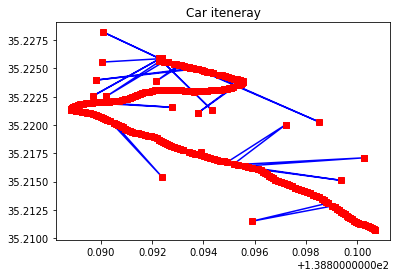

In [127]:

# More visualization 

# let's plot the original data using matplotlib to better understand the origin of the noise 
%matplotlib inline
plt.title('Car iteneray')
plt.plot(data['longitude'].values , data['latitude'].values ,'b')
plt.plot(data['longitude'].values , data['latitude'].values , 'rs')
plt.show()


# Let's visualize The same Data on Actual Maps using mplleaflet
# import mplleaflet
# plt.plot(data['longitude'].values , data['latitude'].values , 'rs')
# # mplleaflet.show()







The plot again clearly shows some undesirable , but existing outliers . 
But at least now we can guess the actual car itenirary 

Text(0.5, 1.0, 'Latitude against time ')

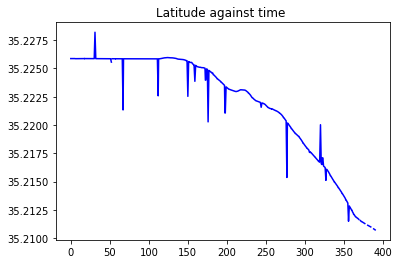

In [128]:
# Let's visualize the latitude  through time 
plt.plot(data['timestamp_secs'].values , data['latitude'].values ,'b')
plt.title('Latitude against time ')

Text(0.5, 1.0, 'Longitute against time ')

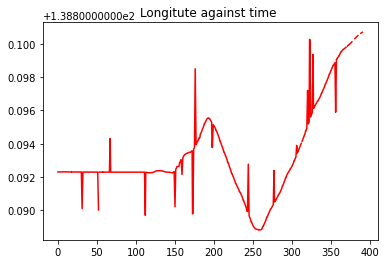

In [129]:
# Let's visualize the longitude  through time 
plt.plot(data['timestamp_secs'].values , data['longitude'].values ,'r')
plt.title('Longitute against time ')

Part 3 : Sensor filtering

As demonstrated in the previous part , our GPS data clearly exhibit spurious signal jumps for erroneous readings.

Goal : 
- Implement a possible approach towards detecting and smoothing our data  .

Approach :  

- First , try out the Ramer-Douglas-Peuker Algorithm 
- If the Ramer-Douglas-Peuker Algorithm  doesnt work or resulted in significant loss of data , then we will use a Kalman filter


536 point reduced to 285 points 


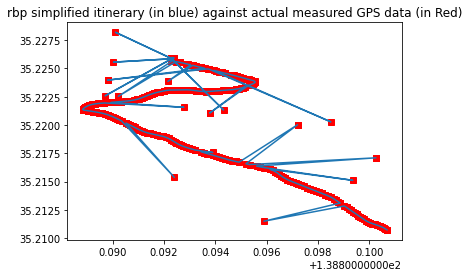

,timestamp_secs,image_id,latitude,longitude,Diff
0,0.000000,NaN,35.22587,138.892307,Skip
1,0.055894,0.0,35.22587,138.892307,0.055894
2,0.997609,NaN,35.22587,138.892307,Skip
3,1.997444,NaN,35.22587,138.892307,Skip
4,2.541349,1.0,35.22587,138.892307,0.492368
5,3.033717,NaN,35.22587,138.892307,Skip
6,3.997913,NaN,35.22587,138.892307,Skip
7,5.004652,NaN,35.22587,138.892307,Skip
8,5.064852,2.0,35.22587,138.892307,0.0602
9,6.012345,NaN,35.22586,138.892315,Skip


In [130]:
# The Ramer-Douglas-Peuker Algorithm
# the  Ramer-Douglas-Peuker Algorithm  is One way of reducing the signal noice 
# It's is a well-known algorithme that omits irrelevant points on an itenary , let's apply it here 
from rdp import rdp
rdp_GPS = pd.DataFrame(rdp(data[['longitude','latitude']].values,epsilon=1e-10))
rdp_GPS.columns=['longitude','latitude']
rdp_GPS.head(5)
# Let's see hw many observations we've reduced by appying the 'rdp'
print('{} point reduced to {} points '.format(data.shape[0],rdp_GPS.shape[0]) )
%matplotlib inline
plt.title('rbp simplified itinerary (in blue) against actual measured GPS data (in Red)')
plt.plot(data['longitude'].values , data['latitude'].values , 'rs')
plt.plot(rdp_GPS['longitude'].values,rdp_GPS['latitude'].values)
plt.show()

data.head(10)




As can be seen on the figure , the rdp algorithm was able to (relatively) recognize and filter out most of the outliers , but at the cost of a huge loss of information . 
The reduced itinerary , and though it may perform pretty well on a straight itinerary (as is the case in the first part of our itenerary ) , it doesnt not do as well when  picking on turns and change of direction (as is the case here) .

For that , We will need a stochastic filter . 
Next up , we will try to imlement a Kalman filter to filter out and smooth the GPS data .


In [131]:
# The Kalman Filter 
#  Prepare Data for Kalman Filter 

data.head(5)

gps_measures = np.ma.masked_invalid(data[['longitude','latitude']].values)
# plt.plot(gps_measures[:,0],gps_measures[:,1] ,'rs')

# gps_measures.index=np.round(gps_measures.index.astype(np.int64),-9).astype('datetime64[ns]')




In [132]:
from pykalman import KalmanFilter

# now let's initialize the Kalman Filter 


transistion_matrix = np.array([ [1, 0, 0.5,0],
                                [0, 1, 0,0.5],
                                [0, 0, 1,0],
                                [0, 0, 0,1]  ])

observation_matrix = np.array ([  [1, 0, 0,0],
                                  [0, 1, 0,0] ])


R = np.diag([100,100])**2

initial_state_mean = np.hstack([gps_measures[0, :], 2*[0.]])
initial_state_cov = np.diag([1e-4 , 1e-4,1e-4,1e-4])
Kf = KalmanFilter (
                   transition_matrices = transistion_matrix ,
                   observation_matrices=observation_matrix  ,
                   observation_covariance=R,
                   initial_state_mean = initial_state_mean,
                   initial_state_covariance = initial_state_cov,
                   em_vars = ['transistion_covariance']
                   
                  )



In [133]:
Kf=Kf.em(gps_measures,n_iter=100) # 100 iteration

In [135]:
state_means , state_vars = Kf.smooth(gps_measures) # apply the filter and store the smoothed coords

([<matplotlib.lines.Line2D at 0x2220c783f10>],
 [<matplotlib.lines.Line2D at 0x2220c7922e0>])

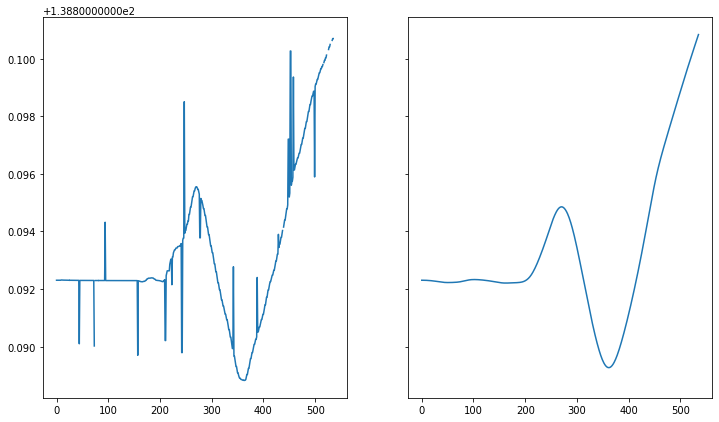

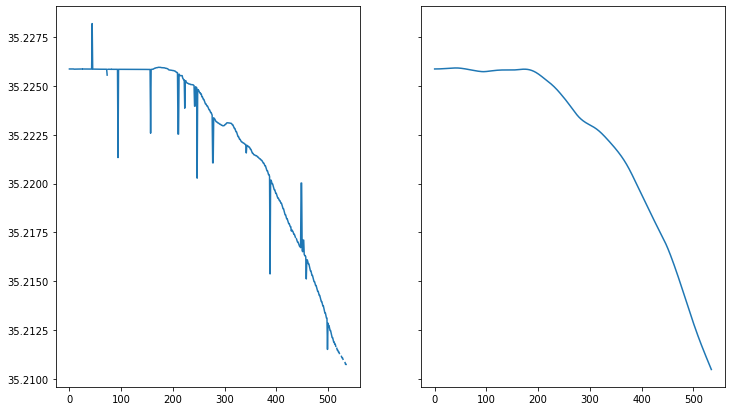

In [136]:
%matplotlib inline
# Now let's Visualize the results 
fig ,(ax1,ax2) = plt.subplots(1,2,sharey=True ,figsize=(12,7))
ax1.plot(gps_measures[:,0]) , ax2.plot(state_means[:,0] )
fig ,(ax1,ax2) = plt.subplots(1,2,sharey=True ,figsize=(12,7))
ax1.plot(gps_measures[:,1]) , ax2.plot(state_means[:,1] )


- Great ! The results are satisfying . We were able to filter out the undesirable noises with the hel of a Kalman Filter 

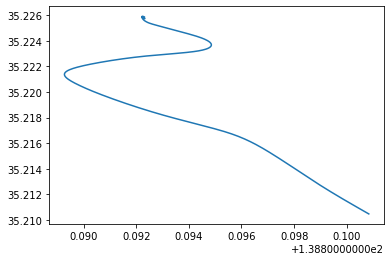

In [138]:
# LEt's check out the smoothed out itinerary 
plt.plot(state_means[:,0],state_means[:,1])

In [139]:
# Let's update our original dataframe with the new filtred coordinates 
data ['longitude']= pd.DataFrame((state_means[:,0]))
data ['latitude']= pd.DataFrame((state_means[:,1]))

In [140]:
# NOw let's visualize the actual itinerary on Folium Maps (Yet again)
visualize_route_with_foliumMaps(data)


Type of a: <class 'list'>


- This is looking good ! we are now alomst done 
- Next up , We will calculate the Car Speed/velocity at each point in time and check for the points where the speed exeeded 50 km/h 

Part 4 : Speed Analysis 

In [151]:
from math import radians, degrees, sin, cos, asin, acos, sqrt

# the Following Function calculates the distance between two GPS Coordinates and returns it in meters     
#         Parameters:
#         lon1, lat1, lon2, lat2 : Coordinates of two diffrent points 
#         Returns: the great circle distance in meters 
            
def great_circle(lon1, lat1, lon2, lat2):
        lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
        return 6371 * 1000 * (
            acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2)) # distance converted to meters 
             )

In [152]:
data_speed=data.dropna(subset=['image_id']) # drop the missing values from the image column
data_speed.reset_index(drop=True, inplace=True)
data_speed.drop(columns= ['Diff'],inplace=True)
data_speed.head(10)

c:\python39\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,timestamp_secs,image_id,latitude,longitude
0,0.055894,0.0,35.225870,138.892307
1,2.541349,1.0,35.225871,138.892306
2,5.064852,2.0,35.225873,138.892304
3,7.547008,3.0,35.225876,138.892301
4,10.083096,4.0,35.225881,138.892296
5,12.554007,5.0,35.225886,138.892291
6,15.001971,6.0,35.225891,138.892285
7,17.509800,7.0,35.225899,138.892276
8,20.066697,8.0,35.225907,138.892266
9,22.575128,9.0,35.225912,138.892258


In [153]:
  
speed = [] #Instantiate an empty list called speed to store speed records list 
distance=[]
time_laps=[]
image_list = []


for (index , row) in data_speed.iterrows(): #iterate over the car location corrdinates DataFrame 
    
    if (index == 0)  : # to skip the first point (speed cannot be calculated for index = 0)
        speed.append(0)
    else:
        distance .append (great_circle(data_speed.loc[index-1 , 'longitude'] , data_speed.loc[ index-1 , 'latitude'] , 
                                       data_speed.loc[index , 'longitude'] , data_speed.loc[ index , 'latitude']))
        
        time_laps.append(data_speed.loc[index , 'timestamp_secs']  - data_speed.loc[ index-1 , 'timestamp_secs']  )

        speed_temp = round(((distance[-1])/(time_laps[-1])* 3.6),2) # temp variable that captures the speed for each iter
        
        if speed_temp > 50 : # if the speed exeeds the 50 km/h limit , add it the image_list
            image_list.append([data_speed.loc[index , 'image_id'], speed_temp] ) 
            
        speed.append( speed_temp )
        speed_temp = 0
        
# adding all the intrest columns to the dataframe 
data_speed ['distance_cruised in metters'] = pd.DataFrame(distance) 
data_speed ['time_laps is Secs'] = pd.DataFrame(time_laps)
data_speed ['speed in km/h'] = pd.DataFrame(speed)
data_speed ['speed_limit in Km/h'] = 50

# visualizing the first 10 rows
data_speed.tail(10)
    


C:\Users\mlaho\AppData\Local\Temp/ipykernel_16200/3225996952.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_speed ['distance_cruised in metters'] = pd.DataFrame(distance)
C:\Users\mlaho\AppData\Local\Temp/ipykernel_16200/3225996952.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_speed ['time_laps is Secs'] = pd.DataFrame(time_laps)
C:\Users\mlaho\AppData\Local\Temp/ipykernel_16200/3225996952.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

,timestamp_secs,image_id,latitude,longitude,distance_cruised in metters,time_laps is Secs,speed in km/h,speed_limit in Km/h
147,367.540147,147.0,35.211853,138.899680,18.411575,2.502697,41.21,50
148,370.042843,148.0,35.211716,138.899792,18.186987,2.526480,26.48,50
149,372.569323,149.0,35.211580,138.899905,26.912106,2.472085,25.91,50
150,375.041408,150.0,35.211380,138.900072,17.740966,2.490982,39.19,50
151,377.532389,151.0,35.211249,138.900182,17.616574,2.548689,25.64,50
152,380.081078,152.0,35.211118,138.900292,17.522186,2.501496,24.88,50
153,382.582575,153.0,35.210989,138.900402,26.171856,2.504871,25.22,50
154,385.087445,154.0,35.210796,138.900567,17.406070,2.508790,37.61,50
155,387.596235,155.0,35.210667,138.900676,17.394416,2.483169,24.98,50
156,390.079404,156.0,35.210539,138.900785,NaN,NaN,25.22,50


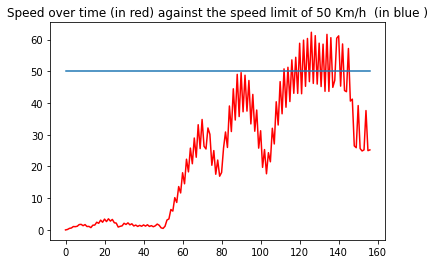

In [154]:
plt.title('Speed over time (in red) against the speed limit of 50 Km/h  (in blue )')
plt.plot(data_speed ['image_id'].values, data_speed ['speed in km/h'].values , 'r')
plt.plot(data_speed ['image_id'].values, data_speed ['speed_limit in Km/h'].values)


Finally , we let's render the final list of image_ids where the vehicle exeeded the speed limit of 50 Km/h

In [155]:
image_list = pd.DataFrame (image_list)
image_list.columns =['Image_id', 'Speed in Km/h']
image_list
# there are 17 points in time where the car exeeded the 50 kn/h speed limit 

,Image_id,Speed in Km/h
0,112.0,50.75
1,114.0,51.25
2,116.0,53.58
3,118.0,54.40
4,120.0,58.82
5,122.0,59.81
6,124.0,60.33
7,126.0,62.29
8,128.0,61.22
9,130.0,58.84


# THank you !